![](images/obspy_logo_full_524x179px.png)

<div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ObsPy: esercizio di download e processamento dati</div>



Per questo esercizio, scaricheremo alcuni dati dal terremoto di Tohoku-Oki, elimineremo un certo intervallo di tempo attorno al primo arrivo e rimuoveremo la risposta dello strumento dai dati.

In [5]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Il primo passo è scaricare tutte le informazioni necessarie usando il client ObsPy FDSN.

Abbiamo bisogno delle seguenti cose:

1. Informazioni sull'evento sul terremoto del Sud Napa del 2014. Usa il metodo `get_events()` del client. Un buon fornitore di dati sugli eventi è l'USGS.
2. Scarica le informazioni relative a stazione/strumento con il metodo `get_stations()`. Scegli la tua stazione preferita! Se non hai preferenze, usa `II.PFO` che è disponibile ad esempio da IRIS.
3. Scarica le forma d'onda della stazione scelta. Usa il metodo `get_waveforms()`.

In [6]:
import obspy
from obspy.clients.fdsn import Client

c_event = Client("USGS")

# Tempo origine del terremoto.
event_time = obspy.UTCDateTime("2014-08-24T10:20:44.0")

# Recupera le informazioni sull'evento. I vincoli temporali e di magnitudo lo rengono unico
cat = c_event.get_events(starttime=event_time - 10, endtime=event_time + 10,
                         minmagnitude=6)
print(cat)

c = Client("IRIS")
# Scarica le informazioni sulla stazione a livello di risposta (level = "response")
inv = c.get_stations(network="II", station="PFO", location="00", channel="BHZ",
                     starttime=event_time - 10 * 60, endtime=event_time + 30 * 60,
                     level="response")
print(inv)

# Sacrica la component 'Z' delle forme d'onda della stazione II.PFO.
st = c.get_waveforms(network="II", station="PFO", location="00",
                     channel="BHZ", starttime=event_time - 10 * 60,
                     endtime=event_time + 30 * 60)
print(st)

1 Event(s) in Catalog:
2014-08-24T10:20:44.070000Z | +38.215, -122.312 | 6.02 mw | manual
Inventory created at 2018-04-23T14:08:25.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2014-08-24...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			II
		Stations (1):
			II.PFO (Pinon Flat, California, USA)
		Channels (1):
			II.PFO.00.BHZ
1 Trace(s) in Stream:
II.PFO.00.BHZ | 2014-08-24T10:10:44.019500Z - 2014-08-24T10:50:43.969500Z | 20.0 Hz, 48000 samples


Diamo un'occhiata ai dati appena scaricati.

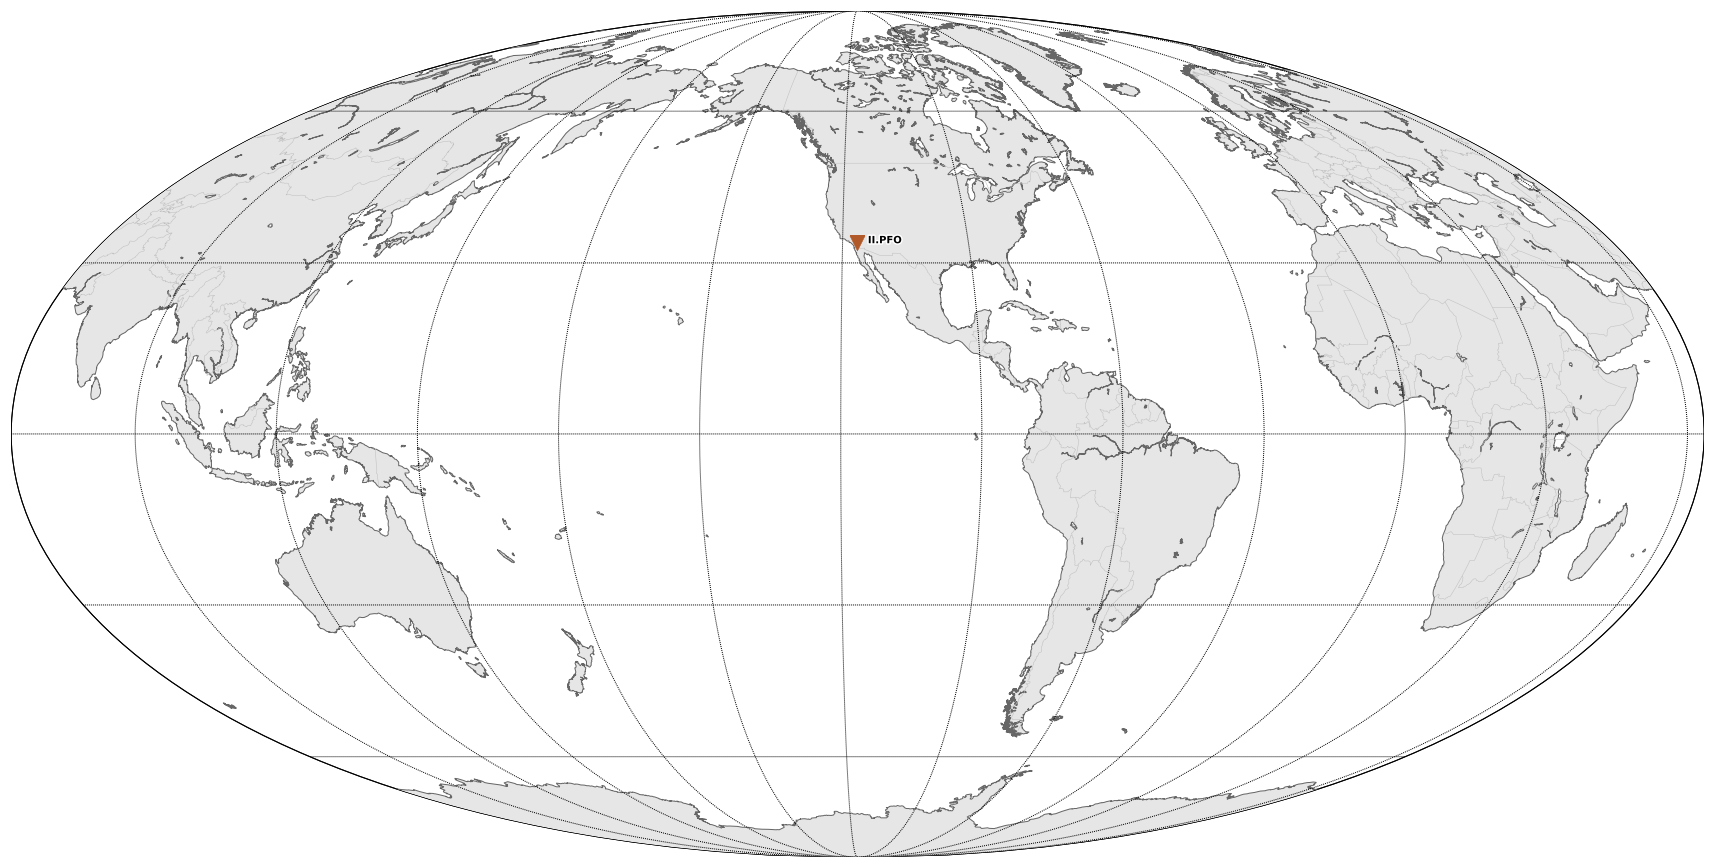

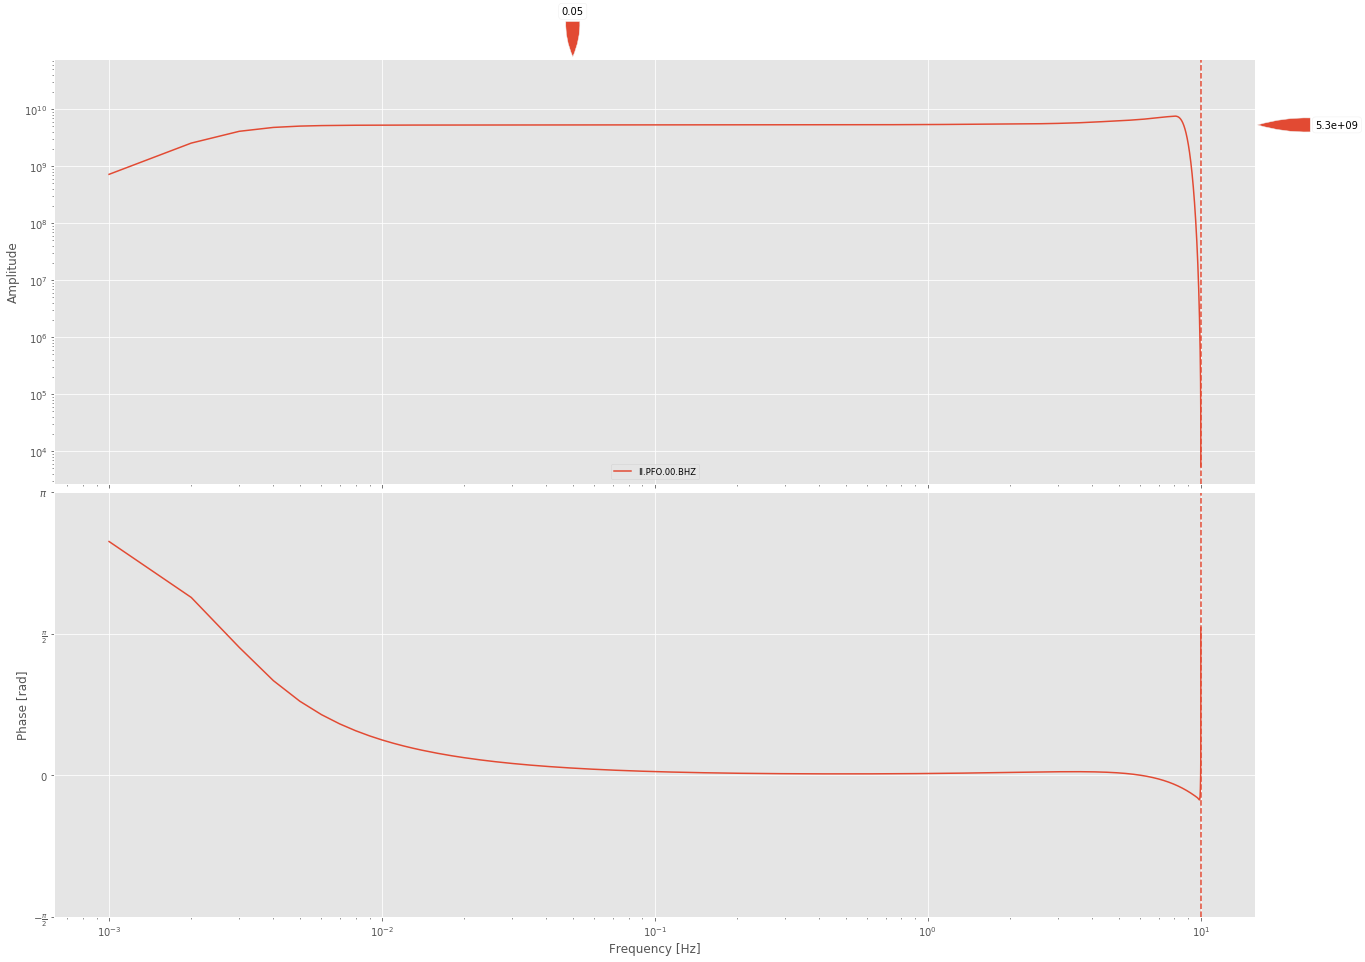

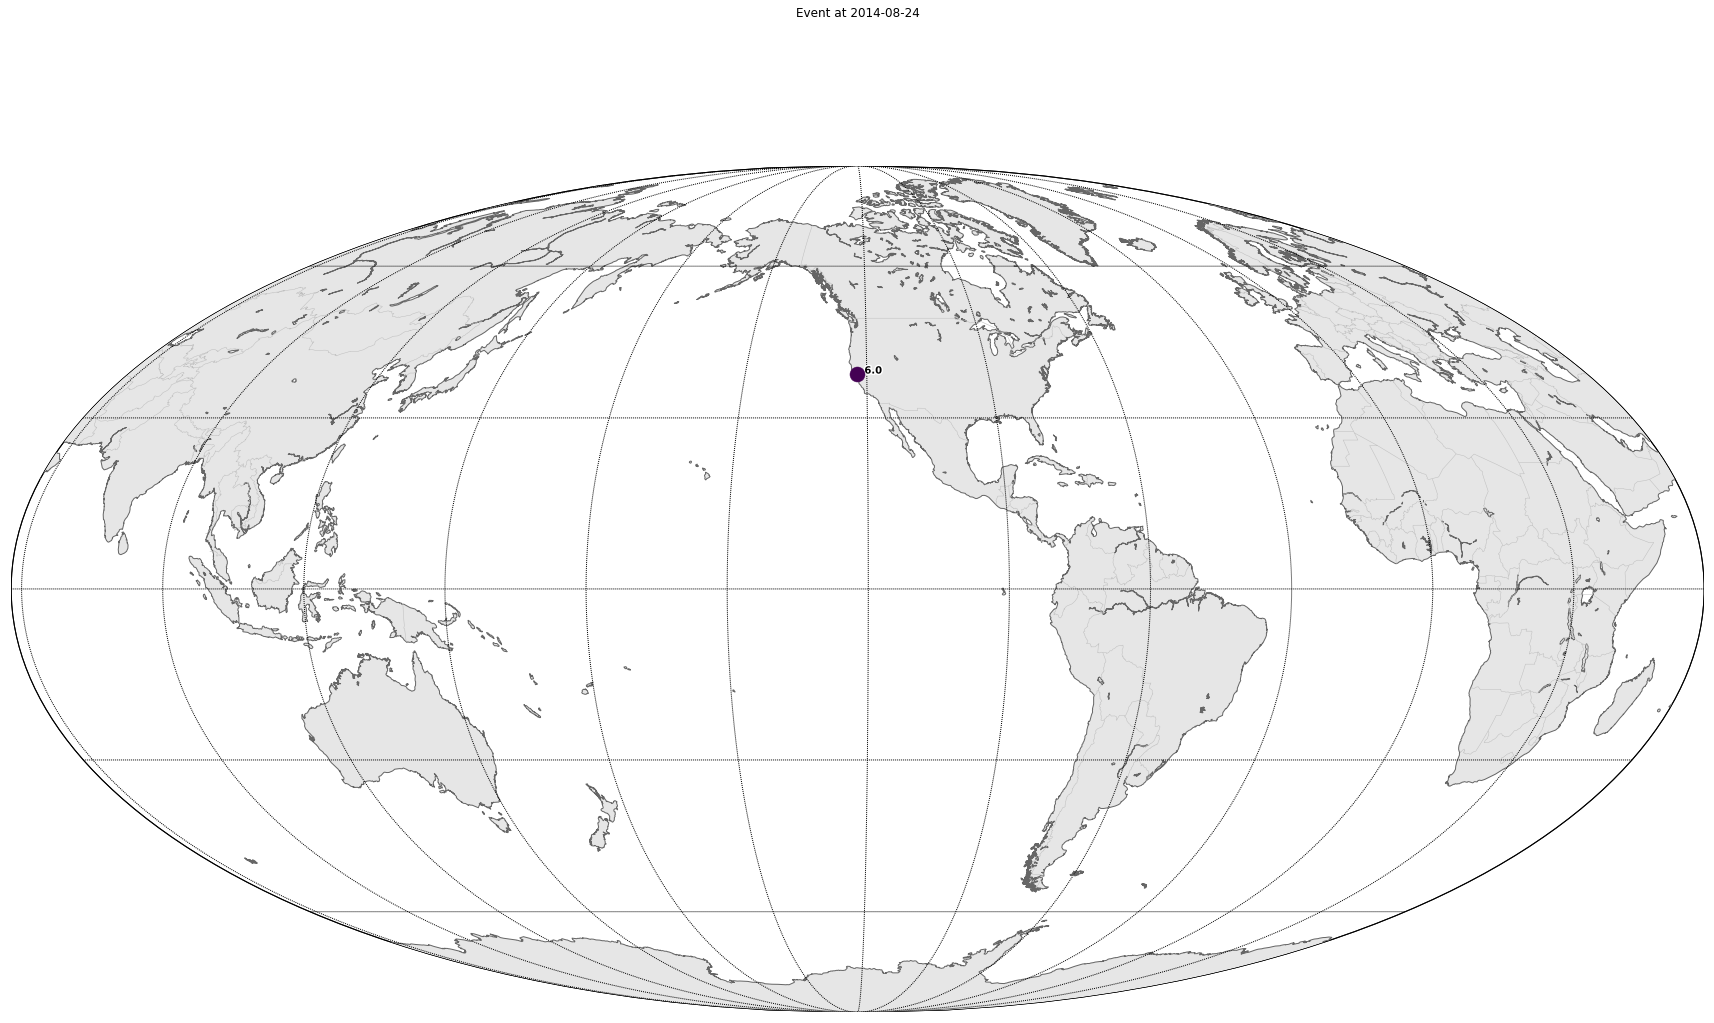

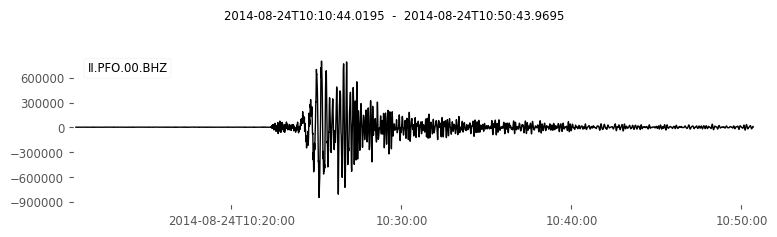

In [3]:
inv.plot()
inv.plot_response(0.001)
cat.plot()
st.plot()

## Esercizio

L'obiettivo di questo esercizio è tagliare i dati da 1 minuto prima del primo arrivo a 5 minuti dopo, quindi rimuovere la risposta dello strumento.



#### Step 1: Determinare le coordinate della stazione

In [4]:
coords = inv.get_coordinates("II.PFO.00.BHZ")
coords

{'elevation': 1280.0,
 'latitude': 33.610699,
 'local_depth': 5.3,
 'longitude': -116.455498}

#### Step 2: Determinare le coordinate dell'evento

In [5]:
origin = cat[0].origins[0]
print(origin)

Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/archive/product/origin/nc72282711/nc/1503942901517/product.xml")
	               time: UTCDateTime(2014, 8, 24, 10, 20, 44, 70000)
	          longitude: -122.3123333
	           latitude: 38.2151667
	              depth: 11120.0 [uncertainty=150.0]
	            quality: OriginQuality(used_phase_count=400, used_station_count=369, standard_error=0.18, azimuthal_gap=28.0, minimum_distance=0.03604)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=110.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='NC', creation_time=UTCDateTime(2017, 8, 28, 17, 55, 1, 517000), version='28')


#### Step 3: Calcolare la distanza di evento e stazione.

Usa `obspy.geodetics.locations2degree`.

In [6]:
from obspy.geodetics import locations2degrees

distance = locations2degrees(origin.latitude, origin.longitude,
                             coords["latitude"], coords["longitude"])
print(distance)

6.607877173574215


#### Step 4: Calcolare gli arrivi teorici

```python
from obspy.taup import TauPyModel
m = TauPyModel(model="ak135")
arrivals = m.get_ray_paths(...)
arrivals.plot()
```

/Users/spina/anaconda2/envs/obspy/lib/python2.7/site-packages/ipykernel_launcher.py:9: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  if __name__ == '__main__':


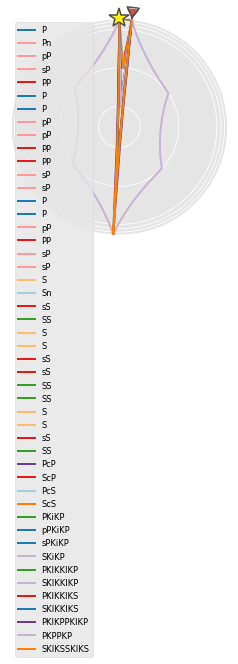

In [7]:
from obspy.taup import TauPyModel

m = TauPyModel(model="ak135")

arrivals = m.get_ray_paths(
    distance_in_degree=distance,
    source_depth_in_km=origin.depth / 1000.0)

arrivals.plot();

#### Step 5: Calcolare il tempo assoluto del primo arrivo alla stazione

In [8]:
first_arrival = origin.time + arrivals[0].time

print(first_arrival)

2014-08-24T10:22:21.096374Z


#### Step 6:  Taglia da 1 minuto prima a 5 minuti dopo il primo arrivo

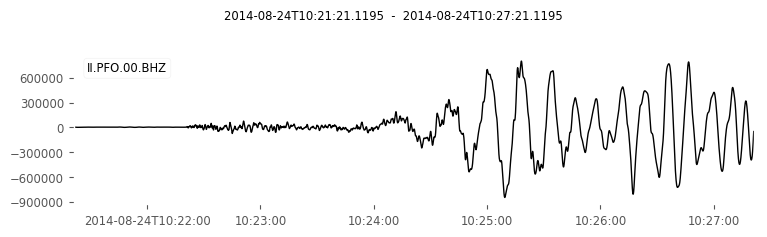

In [9]:
st.trim(first_arrival - 60, first_arrival + 300)
st.plot();

#### Step 7: Remuovere la risposta dello strumento

```python
st.remove_response(inventory=inv, pre_filt=...)
```

![taper](images/cos_taper.png)

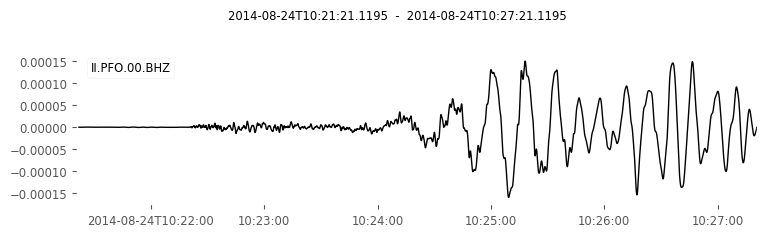

In [10]:
st.remove_response(inventory=inv, 
                   pre_filt=(1.0 / 100.0, 1.0 / 50.0, 10.0, 20.0),
                   output="VEL")
st.plot()

## Bonus: Interactive IPython widgets

In [11]:
from ipywidgets import interact
from obspy.taup import TauPyModel

m = TauPyModel("ak135")

def plot_raypaths(distance, depth, wavetype):
    try:
        plt.close()
    except:
        pass
    if wavetype == "ttall":
        phases = ["ttall"]
    elif wavetype == "diff":
        phases = ["Pdiff", "pPdiff"]
    m.get_ray_paths(distance_in_degree=distance,
                    source_depth_in_km=depth,
                    phase_list=phases).plot();
    
interact(plot_raypaths, distance=(1, 180),
         depth=(0, 700), wavetype=["ttall", "diff"]);

interactive(children=(IntSlider(value=90, description=u'distance', max=180, min=1), IntSlider(value=350, description=u'depth', max=700), Dropdown(description=u'wavetype', options=('ttall', 'diff'), value='ttall'), Output()), _dom_classes=('widget-interact',))